# Numerical experiments II (diagnostics)

### Notebook written by Matteo Sesia and Yaniv Romano
#### Stanford University, Department of Statistics
#### Last updated on: November 19, 2018

The purpose of this notebook is to allow the numerical experiments described in the paper to be reproduced easily.
Running this code may take a few minutes on a graphical graphical processing unit.

## Load the required libraries

Additional dependencies for this notebook: 

- `torch_two_sample` https://github.com/josipd/torch-two-sample

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from DeepKnockoffs import KnockoffMachine
from DeepKnockoffs import GaussianKnockoffs
import data
import diagnostics
import parameters

## Data generating model

We model $X \in \mathbb{R}^p $ as a multivariate Student's-t distribution, with $p=100$ and the covariance matrix of an auto-regressive process of order one. The default correlation parameter for this distribution is $\rho =0.5$ and the number of degrees of freedom $\nu = 3$.

In [2]:
# Number of features
p = 100

# Load the built-in multivariate Student's-t model and its default parameters
# The currently available built-in models are:
# - gaussian : Multivariate Gaussian distribution
# - gmm      : Gaussian mixture model
# - mstudent : Multivariate Student's-t distribution
# - sparse   : Multivariate sparse Gaussian distribution 
model = "mstudent"
distribution_params = parameters.GetDistributionParams(model, p)

# Initialize the data generator
DataSampler = data.DataSampler(distribution_params)

## Second-order knockoffs

After computing the empirical covariance matrix of $X$ in the training dataset, we can initialize a generator of second-order knockoffs. The solution of the SDP determines the pairwise correlations between the original variables and the knockoffs produced by this algorithm.

In [3]:
# Number of training examples
n = 10000

# Sample training data
X_train = DataSampler.sample(n)
print("Generated a training dataset of size: %d x %d." %(X_train.shape))

# Compute the empirical covariance matrix of the training data
SigmaHat = np.cov(X_train, rowvar=False)

# Initialize generator of second-order knockoffs
second_order = GaussianKnockoffs(SigmaHat, mu=np.mean(X_train,0), method="sdp")

# Measure pairwise second-order knockoff correlations 
corr_g = (np.diag(SigmaHat) - np.diag(second_order.Ds)) / np.diag(SigmaHat)

print('Average absolute pairwise correlation: %.3f.' %(np.mean(np.abs(corr_g))))

Generated a training dataset of size: 10000 x 100.
Average absolute pairwise correlation: 0.449.


## Deep knockoff machine

The default parameters of the machine are set below, as most appropriate for the specific built-in model considered.

In [4]:
# Load the default hyperparameters for this model
training_params = parameters.GetTrainingHyperParams(model)

# Set the parameters for training deep knockoffs
pars = dict()
# Number of epochs
pars['epochs'] = 100
# Number of iterations over the full data per epoch
pars['epoch_length'] = 100
# Data type, either "continuous" or "binary"
pars['family'] = "continuous"
# Dimensions of the data
pars['p'] = p
# Size of the test set
pars['test_size']  = 0
# Batch size
pars['batch_size'] = int(0.5*n)
# Learning rate
pars['lr'] = 0.01
# When to decrease learning rate (unused when equal to number of epochs)
pars['lr_milestones'] = [pars['epochs']]
# Width of the network (number of layers is fixed to 6)
pars['dim_h'] = int(10*p)
# Penalty for the MMD distance
pars['GAMMA'] = training_params['GAMMA']
# Penalty encouraging second-order knockoffs
pars['LAMBDA'] = training_params['LAMBDA']
# Decorrelation penalty hyperparameter
pars['DELTA'] = training_params['DELTA']
# Target pairwise correlations between variables and knockoffs
pars['target_corr'] = corr_g
# Kernel widths for the MMD measure (uniform weights)
pars['alphas'] = [1.,2.,4.,8.,16.,32.,64.,128.]

Let's load the trained machine stored in the `tmp/` subdirectory.

In [5]:
# Where the machine is stored
checkpoint_name = "tmp/" + model

# Initialize the machine
machine = KnockoffMachine(pars)

# Load the machine
machine.load(checkpoint_name)

=> loading checkpoint 'tmp/mstudent_checkpoint.pth.tar'
=> loaded checkpoint 'tmp/mstudent_checkpoint.pth.tar' (epoch 100)


## Knockoff diagnostics on test data

The knockoff generator can be used on new observations of $X$.

In [6]:
# Compute goodness of fit diagnostics on 50 test sets containing 100 observations each
n_exams = 100
n_samples = 1000
exam = diagnostics.KnockoffExam(DataSampler,
                                {'Machine':machine, 'Second-order':second_order})
diagnostics = exam.diagnose(n_samples, n_exams)

Computing knockoff diagnostics...
[=========================] 100%

In [7]:
# Summarize diagnostics
diagnostics.groupby(['Method', 'Metric', 'Swap']).describe()

Value                                     \
                                 count       mean         std         min   
Method       Metric     Swap                                                
Machine      Covariance full     100.0  60.039512  134.123940 -276.697998   
                        partial  100.0  33.986291  147.058595 -735.524170   
                        self     100.0   0.471787    0.014590    0.446446   
             Energy     full     100.0   0.033835    0.003786    0.027217   
                        partial  100.0   0.033376    0.003730    0.026927   
             KNN        full     100.0   0.519685    0.010931    0.494000   
                        partial  100.0   0.518700    0.011344    0.482500   
             MMD        full     100.0   0.000217    0.000439   -0.000461   
                        partial  100.0   0.000173    0.000434   -0.000490   
Second-order Covariance full     100.0  22.223158   79.669380 -258.176270   
                        partial  100.0  14.609053   78.543943 -336.269531   
                        self     100.0   0.417068    0.015437    0.388371   
             Energy     full     100.0   0.039277    0.003011    0.033520   
                        partial  100.0   0.037695    0.003078    0.031986   
             KNN        full     100.0   0.664045    0.013599    0.622000   
                        partial  100.0   0.594015    0.015404    0.558000   
             MMD        full     100.0   0.000706    0.000286    0.000186   
                        partial  100.0   0.000408    0.000284    0.000002   

                                                                               
                                       25%        50%        75%          max  
Method       Metric     Swap                                                   
Machine      Covariance full     15.567154  34.559479  60.759216  1152.463867  
                        partial   0.082489  17.216095  39.111130  1097.638184  
                        self      0.462604   0.469675   0.477684     0.539238  
             Energy     full      0.031173   0.033427   0.035757     0.045670  
                        partial   0.030932   0.032650   0.035273     0.045102  
             KNN        full      0.511875   0.520000   0.527500     0.541500  
                        partial   0.511375   0.519500   0.527000     0.541000  
             MMD        full     -0.000110   0.000115   0.000452     0.001579  
                        partial  -0.000127   0.000072   0.000359     0.001574  
Second-order Covariance full      1.077179  11.793976  24.812195   699.819336  
                        partial  -3.392410   6.426788  18.595520   647.122803  
                        self      0.407081   0.414057   0.424322     0.474060  
             Energy     full      0.037035   0.039157   0.040847     0.048149  
                        partial   0.035179   0.037242   0.039380     0.046953  
             KNN        full      0.654750   0.665500   0.674500     0.697000  
                        partial   0.584375   0.595000   0.604250     0.632500  
             MMD        full      0.000492   0.000666   0.000838     0.001652  
                        partial   0.000211   0.000350   0.000533     0.001354

The distribution of the diagnostics corresponding to the covariance test are shown below.

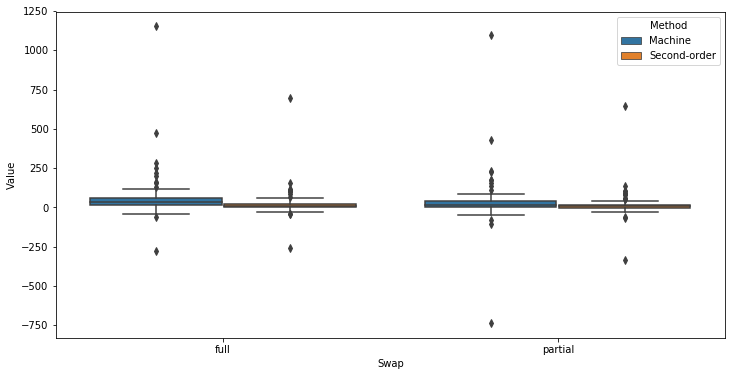

In [8]:
# Plot covariance goodness-of-fit statistics
data = diagnostics[(diagnostics.Metric=="Covariance") & (diagnostics.Swap != "self")]
fig,ax = plt.subplots(figsize=(12,6))
sns.boxplot(x="Swap", y="Value", hue="Method", data=data)
fig

Similarly, we can plot the diagnostics corresponding to differet tests.

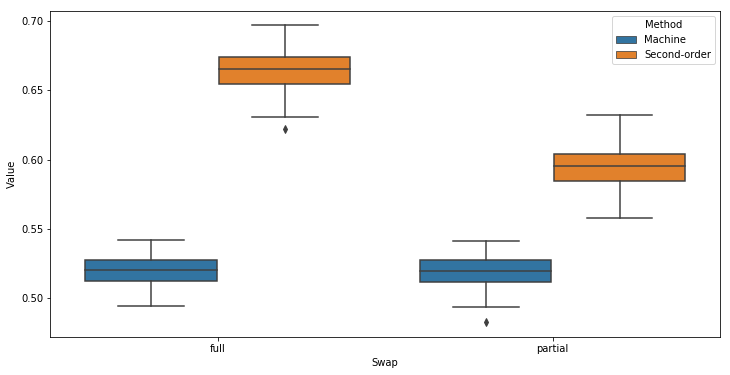

In [9]:
# Plot k-nearest neighbors goodness-of-fit statistics
data = diagnostics[(diagnostics.Metric=="KNN") & (diagnostics.Swap != "self")]
fig,ax = plt.subplots(figsize=(12,6))
sns.boxplot(x="Swap", y="Value", hue="Method", data=data)
fig

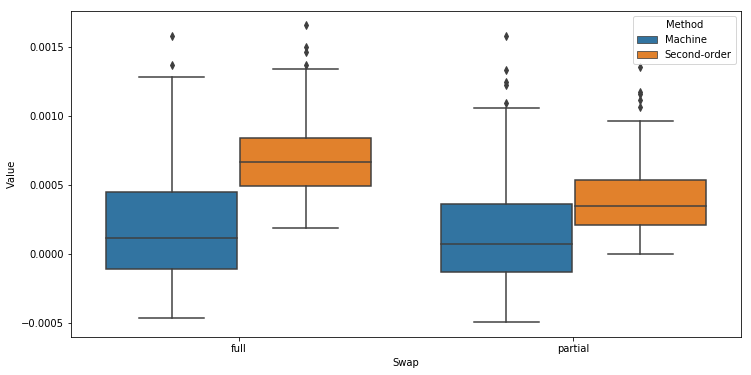

In [10]:
# Plot MMD goodness-of-fit statistics
data = diagnostics[(diagnostics.Metric=="MMD") & (diagnostics.Swap != "self")]
fig,ax = plt.subplots(figsize=(12,6))
sns.boxplot(x="Swap", y="Value", hue="Method", data=data)
fig

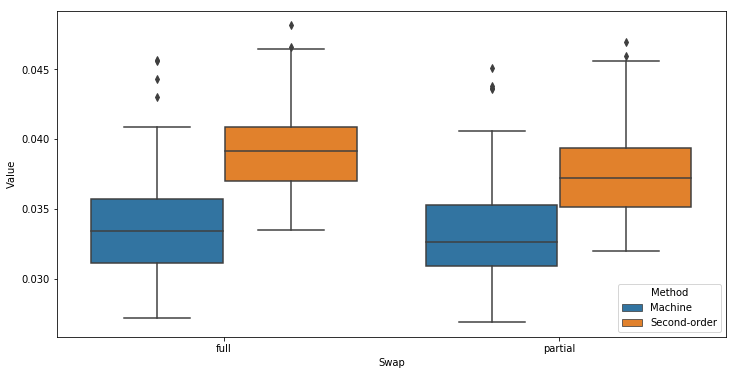

In [11]:
# Plot energy goodness-of-fit statistics
data = diagnostics[(diagnostics.Metric=="Energy") & (diagnostics.Swap != "self")]
fig,ax = plt.subplots(figsize=(12,6))
sns.boxplot(x="Swap", y="Value", hue="Method", data=data)
fig

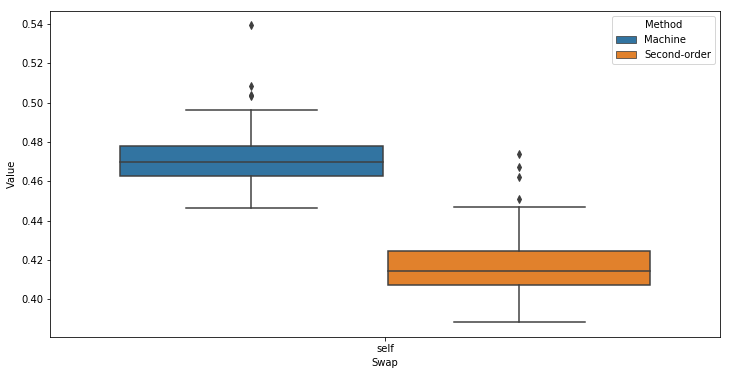

In [12]:
# Plot average absolute pairwise correlation between variables and knockoffs
data = diagnostics[(diagnostics.Metric=="Covariance") & (diagnostics.Swap == "self")]
fig,ax = plt.subplots(figsize=(12,6))
sns.boxplot(x="Swap", y="Value", hue="Method", data=data)
fig